# Estudo de caso     
### Estudo de criação de IA para automação de autorização de empréstimos
https://raw.githubusercontent.com/chrisdmell/DataScience/master/data_dump/01_cipla_ds_challenge/train.csv      
https://www.youtube.com/watch?v=5D8IT-r-s0U&t=275s



#### Bibliotecas

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
warnings.filterwarnings('ignore')

#### Base de dados

In [99]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  30000 non-null  object 
 1   Name                         30000 non-null  object 
 2   Gender                       29947 non-null  object 
 3   Age                          30000 non-null  int64  
 4   Income (USD)                 25424 non-null  float64
 5   Income Stability             28317 non-null  object 
 6   Profession                   30000 non-null  object 
 7   Type of Employment           22730 non-null  object 
 8   Location                     30000 non-null  object 
 9   Loan Amount Request (USD)    30000 non-null  float64
 10  Current Loan Expenses (USD)  29828 non-null  float64
 11  Expense Type 1               30000 non-null  object 
 12  Expense Type 2               30000 non-null  object 
 13  Dependents      

- **Customer ID**: id do cliente (descartar)
- **Name**: nome do cliente(descartar)
- **Gender**: genero do cliente 
- **Age**: idade do cliente
- **Income**: renda do cliente
- **Income Stability**: estabilidade da renda (alta/baixa)
- **Profession**: profissão do cliente
- **Type of Employment**: tipo de emprego do cliente
- **Location**: localização atual de residência
- **Loan Amount Request (USD)**: quantia de empréstimo solicitada
- **Current Loan Expenses (USD)**: despesa mensal de empréstimo
- **Expense Type 1**: gastos do tipo 1 
- **Expense Type 2**: gastos do tipo 2
- **Dependents**: dependentes (conjugue/pais/irmaos/filhos)
- **Credit Score**: pontuação de crédito
- **No. of Defaults**: numero de inadimplencias
- **Has Active Credit Card**: se possui cartao de credito ativo
- **Property ID**: identificação da propriedade (descartar)
- **Property Age**: idade da propriedade
- **Property Type**: tipo de propriedade (4 tipos)
- **Property Location**: localização da propriedade
- **Co-Applicant**: co-requerente
- **Property Price**: preço da propriedade
- **Loan Sanction Amount (USD)**: Quantia de empréstimo sancionada

#### Data wrangling

In [100]:
# 1. descartar colunas irrelevantes
df.drop(['Customer ID', 'Name', 'Property ID'], axis=1, inplace=True)

In [101]:
# 2. Converter os tipos de dados
def conv_col(frame, col, type):
    return frame[col].astype(type)

cols = ['Gender', 'Income Stability', 'Profession', 'Type of Employment']

for i in range(len(cols)):
    df[cols[i]] = conv_col(frame=df, col=cols[i], type='str')

df['Credit Score'] = conv_col(df, 'Credit Score', 'float')

In [102]:
df.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  30000 non-null  object
 1   Income Stability        30000 non-null  object
 2   Profession              30000 non-null  object
 3   Type of Employment      30000 non-null  object
 4   Location                30000 non-null  object
 5   Expense Type 1          30000 non-null  object
 6   Expense Type 2          30000 non-null  object
 7   Has Active Credit Card  28434 non-null  object
 8   Property Location       29644 non-null  object
dtypes: object(9)
memory usage: 2.1+ MB


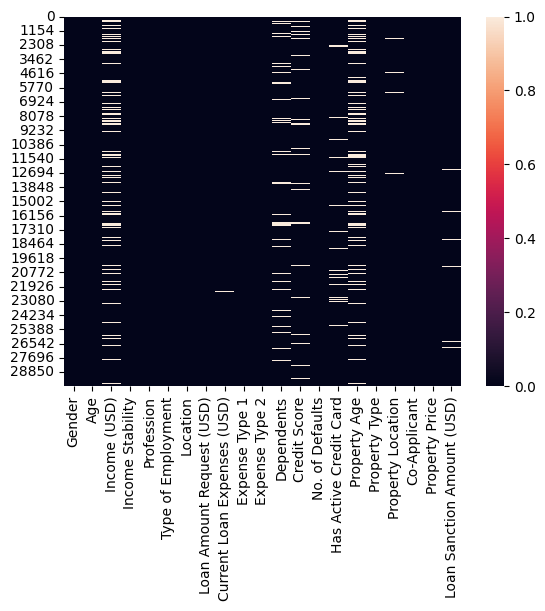

In [103]:
# 3. tratar valores faltantes
sns.heatmap(df.isnull());

In [104]:
# Income
df.loc[df['Income (USD)'].isnull(), 'Income (USD)'] = df['Income (USD)'].median()


In [105]:
# Type of employment
df.loc[df['Type of Employment'].isnull(), 'Type of Employment'] = df['Type of Employment'].mode()[0]

In [106]:
# Demais colunas
df.loc[df['Gender'].isnull(), 'Gender'] = 'Not Specified'
df.loc[df['Income Stability'].isnull(), 'Income Stability'] = 'Unknown'
df.loc[df['Dependents'].isnull(), 'Dependents'] = df['Dependents'].median()
df.loc[df['Credit Score'].isnull(), 'Credit Score'] = df['Credit Score'].median()
df.loc[df['Property Age'].isnull(), 'Property Age'] = df['Property Age'].median()
df.loc[df['Property Location'].isnull(), 'Property Location'] = 'Unknown'

In [107]:
# 4. Corrigir valores inconsistentes
df[['Current Loan Expenses (USD)', 'Property Price']].describe().T

,count,mean,std,min,25%,50%,75%,max
Current Loan Expenses (USD),29828.0,400.936876,242.545375,-999.0,247.6675,375.205,521.2925,3840.88
Property Price,30000.0,131759.680252,93549.548104,-999.0,60572.1600,109993.610,178880.7200,1077966.73


In [108]:
# Current Loan Expenses (USD)
df['Current Loan Expenses (USD)'] = df['Current Loan Expenses (USD)'].apply(lambda x: abs(x))

# Property Price
df['Property Price'] = df['Property Price'].apply(lambda x: max(x,0))

df[['Current Loan Expenses (USD)', 'Property Price']].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Current Loan Expenses (USD),29828.0,412.79,221.77,33.76,251.28,377.98,526.08,3840.88
Property Price,30000.0,131771.40,93532.97,0.00,60572.16,109993.61,178880.72,1077966.73


In [109]:
# Co-Applicant
df['Co-Applicant'].value_counts() 

Co-Applicant
 1      25516
 0       4316
-999      168
Name: count, dtype: int64

In [110]:
df['Co-Applicant'] = df['Co-Applicant'].apply(lambda x: 1 if x > 0 else 0)
df['Co-Applicant'].value_counts() 

Co-Applicant
1    25516
0     4484
Name: count, dtype: int64

#### EDA

In [111]:
# Estatísticas descritivas
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Age,30000.0,40.09,16.05,18.00,25.00,40.00,55.00,65.00
Income (USD),30000.0,2568.32,10369.24,377.70,1743.30,2222.44,2869.14,1777460.21
Loan Amount Request (USD),30000.0,88826.33,59536.95,6048.24,41177.76,75128.08,119964.60,621497.82
Current Loan Expenses (USD),29828.0,412.79,221.77,33.76,251.28,377.98,526.08,3840.88
Dependents,30000.0,2.23,0.91,1.00,2.00,2.00,3.00,14.00
Credit Score,30000.0,739.88,70.09,580.00,685.42,739.82,795.14,896.26
No. of Defaults,30000.0,0.19,0.40,0.00,0.00,0.00,0.00,1.00
Property Age,30000.0,2565.18,10368.16,377.70,1749.81,2223.25,2849.57,1777460.21
Property Type,30000.0,2.46,1.12,1.00,1.00,2.00,3.00,4.00
Co-Applicant,30000.0,0.85,0.36,0.00,1.00,1.00,1.00,1.00


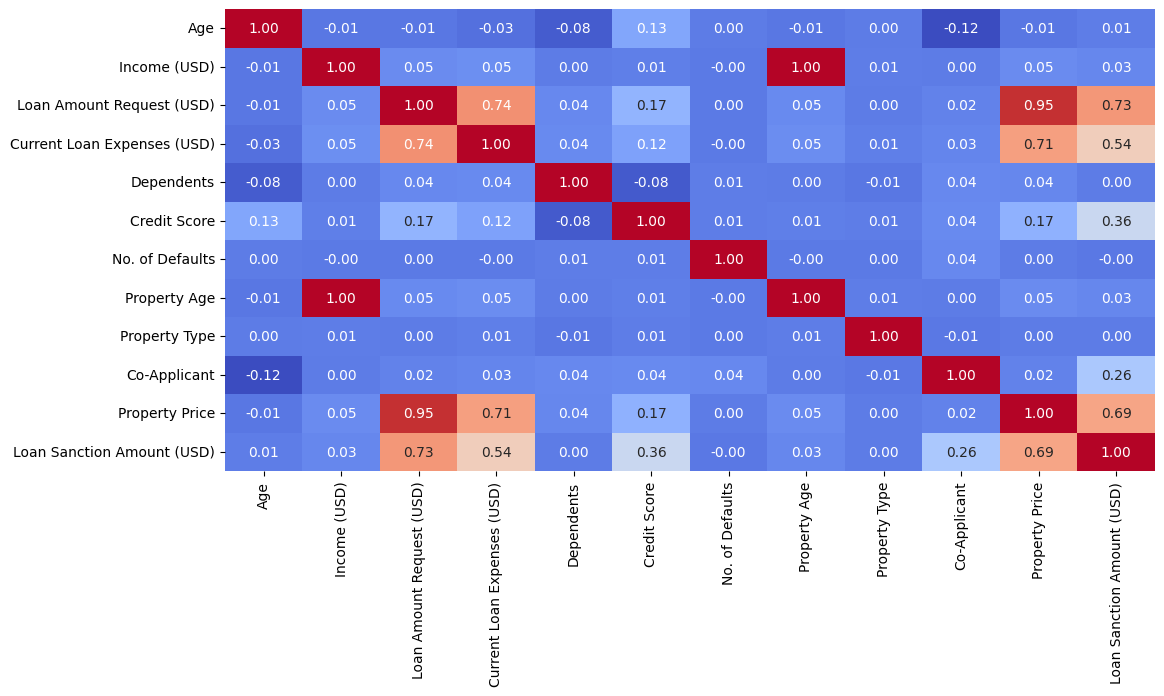

In [133]:
# Correlações
plt.figure(figsize=(12, 6))
sns.heatmap(data=df.select_dtypes(['float', 'int']).corr(),
            cmap='coolwarm',
            cbar=False,
            annot=True,
            fmt='.2f');

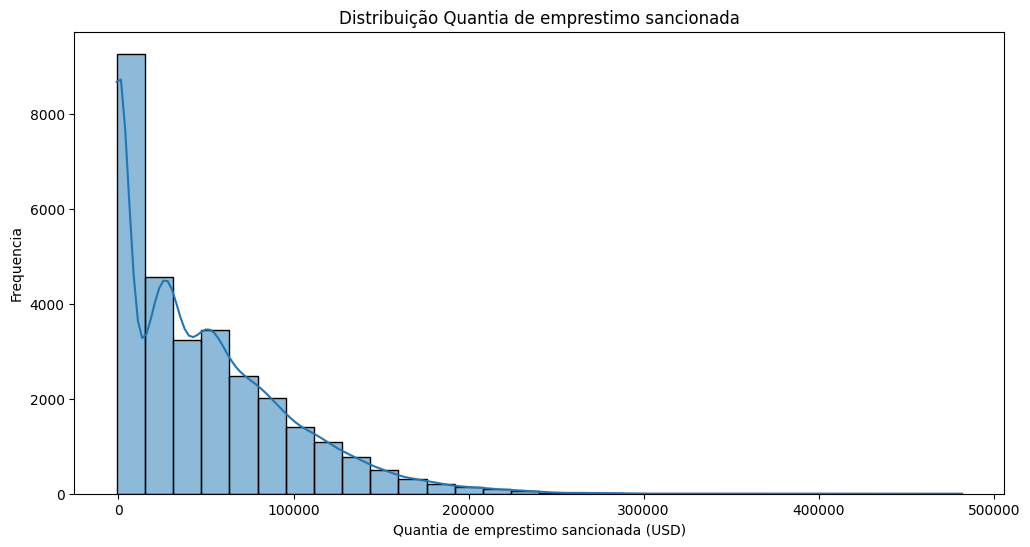

In [129]:
# Histogramas
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Loan Sanction Amount (USD)', bins=30, kde=True)
plt.title('Distribuição Quantia de emprestimo sancionada')
plt.xlabel('Quantia de emprestimo sancionada (USD)')
plt.ylabel(('Frequencia'));

Text(0.5, 1.0, 'Distribuição Quantia de emprestimo sancionada')

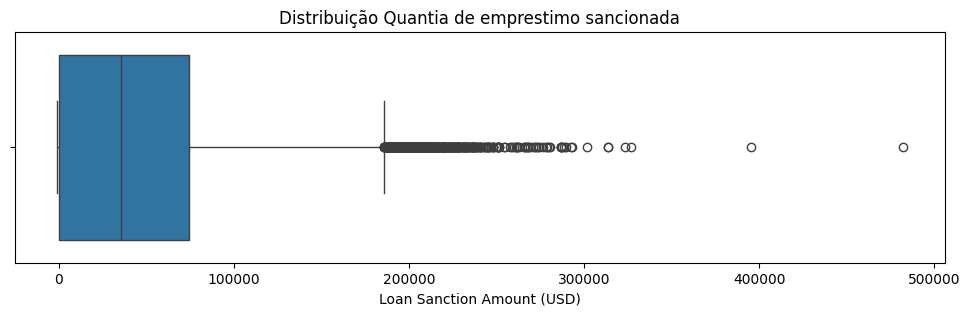

In [132]:
# Boxplots
plt.figure(figsize=(12, 3))
sns.boxplot(data=df, x='Loan Sanction Amount (USD)')
plt.title('Distribuição Quantia de emprestimo sancionada')


In [135]:
# Tratamento de valores negativos para 'Loan Santion Amount (USD)'
df['Loan Sanction Amount (USD)'] = df['Loan Sanction Amount (USD)'].apply(lambda x: max(x, 0))

In [136]:
# Tratamento de outliers para 'Income (USD)' e 'Property Age' (IQR ou z-score)
Q1 = df['Income (USD)'].quantile(0.25)
Q3 = df['Income (USD)'].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = ~df['Income (USD)'].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)
df.loc[outlier_condition, 'Income (USD)'] = np.nan
df.loc[df['Income (USD)'].isnull(), 'Income (USD)'] = df['Income (USD)'].median()

In [142]:
#df['Property Age'].plot(kind='box');

In [145]:
# Tratamento de multicolinearidade 

# 1. Carregamento dos dados tratados

# 2. Calculo da matrix de correlação
corr_mat = df.select_dtypes(['float', 'int']).corr()

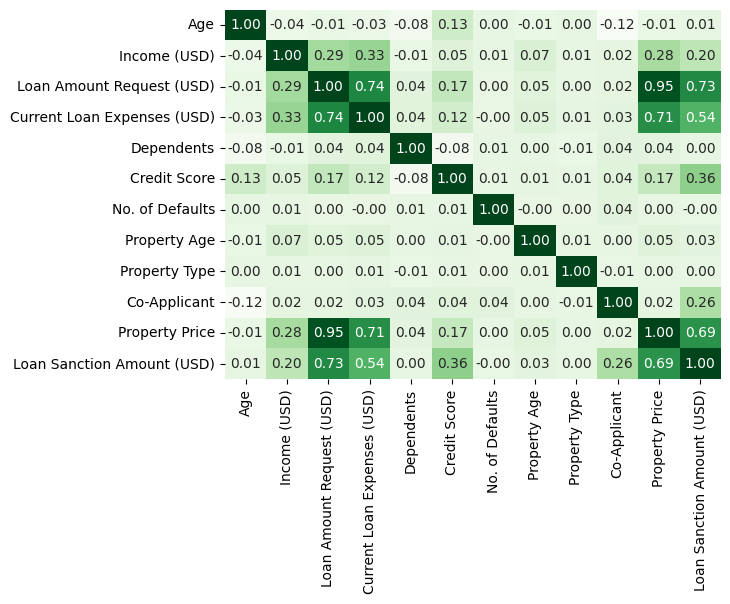

In [146]:
# 3. Visualizar a matriz de correlação
sns.heatmap(data=corr_mat, annot=True, fmt='.2f', cmap='Greens', cbar=False);

In [149]:
# 4. Assegurar que o dataframe só possua variáveis numéricas
num_df = df.select_dtypes(include=[np.number])

# Tratando valores ausentes e infinitos
num_df = num_df.replace([np.inf, -np.inf], np.nan)
num_df = num_df.dropna(axis=0) # remove linhas com nan

In [152]:
# 5. Calcular o VIF
vif_data = pd.DataFrame()
vif_data['feature'] = num_df.columns
vif_data['VIF'] = [vif(num_df.values, i) for i in range(num_df.shape[1])]
print(vif_data.sort_values('VIF', ascending=False)) 

# VIF equal to 1 = variables are not correlated. 
# VIF between 1 and 5 = variables are moderately correlated. 
# VIF greater than 5 = variables are highly correlated2.

                        feature        VIF
2     Loan Amount Request (USD)  40.638127
10               Property Price  29.912662
5                  Credit Score  29.864216
1                  Income (USD)  10.440668
3   Current Loan Expenses (USD)  10.265063
0                           Age   7.377599
9                  Co-Applicant   7.199868
4                    Dependents   6.609410
8                 Property Type   5.682721
11   Loan Sanction Amount (USD)   4.669020
6               No. of Defaults   1.243401
7                  Property Age   1.067075


In [ ]:
# Substituir infinitos por nan e depois trata-los
num_df_reduced = num_df_reduced